# Train Detectors

In this notebook we will train an image classifier that classify fruit images, using MMClassificaiton.

## Prepare a Dataset

We have already prepared a dataset.

Credit to Zihao: https://github.com/TommyZihao/MMClassification_Tutorials

To download and extract the dataset, in command line:

```
curl https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip -o kitti_tiny.zip
unzip -d data kitti_tiny.zip
```

The dataset should be categorized by folders, for MMClassification to read.

## Prepare a Config and Checkpoint File

For speed consideration, we use a lightweight neural network, MobileNetV2.

we use mim to download the config file and checkpoint file.

```
mim download mmcls --config mobilenet-v2_8xb32_in1k --dest .
```

If you prefer to play with other models, navigate to [MMClassification model zoo](https://mmclassification.readthedocs.io/en/latest/model_zoo.html).

In [2]:
!mim download mmdet --config retinanet_r18_fpn_1x_coco --dest . 

processing retinanet_r18_fpn_1x_coco...
downloading -------------------------------- 81.7/81.7 MiB 2.3 MB/s eta 0:00:00
Successfully downloaded retinanet_r18_fpn_1x_coco_20220407_171055-614fd399.pth to c:\wangruohui\桌面\sjtu-openmmlab-tutorial
Successfully dumped retinanet_r18_fpn_1x_coco.py to c:\wangruohui\桌面\sjtu-openmmlab-tutorial


C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Format Dataset

Definition of Kitti annotation can be found [here](https://github.com/bostondiditeam/kitti/blob/master/resources/devkit_object/readme.txt#L46).

To train with MMDetection, we need to write some codes to convert it to the following format:

```python
[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray, float32> (n, 4),
            'labels': <np.ndarray, int64> (n, ),
            'bboxes_ignore': <np.ndarray, float32> (k, 4),
            'labels_ignore': <np.ndarray, int64> (k, ) (optional field)
        }
    },
    ...
]
```

## Modify the Config File

1. Remove some intermediate item for clean: `dataset_type`, `img_norm_cfg`, `train_pipeline`, `test_pipeline`
1. Modify model
    1. number of class: from 1000 to 30
    2. pretrain weights: from None to the downloaded checkpoint file, as we finetune the model instead of training from scratch
1. Data: for train/val/test 
    1. `type`: `ImageNet` -> `CustomDataset`
    2. `prefix`, which is the root path to images: modify to `"data/fruit30_split/train"` or `"data/fruit30_split/val"`
    3. `ann_file`, use folder name as class name: modify to `None`
1. Runner and Optimizer
    1. number of training epochs: `runner.max_epochs`
    1. learning rates: `optimizer.lr`, usually divided by 8 due to linear scaling rules.
1. Misc
    1. Decrease `log_confg.interval` for small computation power
    1. Increase `checkpoint_config.interval` to avoid saving too many checkpoint, to same time and disk space
1. Further parameter tuning you may try
    1. learning rates: Decrease `optimizer.lr` for finetuning 
    1. configure learning scheduler to decrease learning when loss saturates. Moreover, by setting `by_epoch=False`, we decrease learning rate by iteration instead of by epoches.
    1. Monitor loss decrease and re-tune
    1. More available lr_schedulers are available in [mmcv](https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/lr_updater.py)

## Launch Training

In command line

```
mim train mmdet yolox_tiny_kitti.py
```

## Understand Logs


The log is long but mainly contains the following parts:

1. Toolbox information
2. Dumped Config files
3. Model Initialization Logs
    1. Check `mmcls - INFO - load checkpoint from local path: mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth`, which means pretrained weights are loaded correctly.
4. Information on Hooks: we don't configure this explicitly in this tutorial, so ignore that
5. Training progress
    1. Training logs: including current learning, training loss, time consumption, memory occupation
    2. Validation logs: Accuracy on validation set

## Test the Model

The trained model (checkpoint file) is usually saved under `work_dirs/{experiment_name}/latest.pth`. 
We can load it to test with a new image. 

load checkpoint from local path: work_dirs/latest.pth


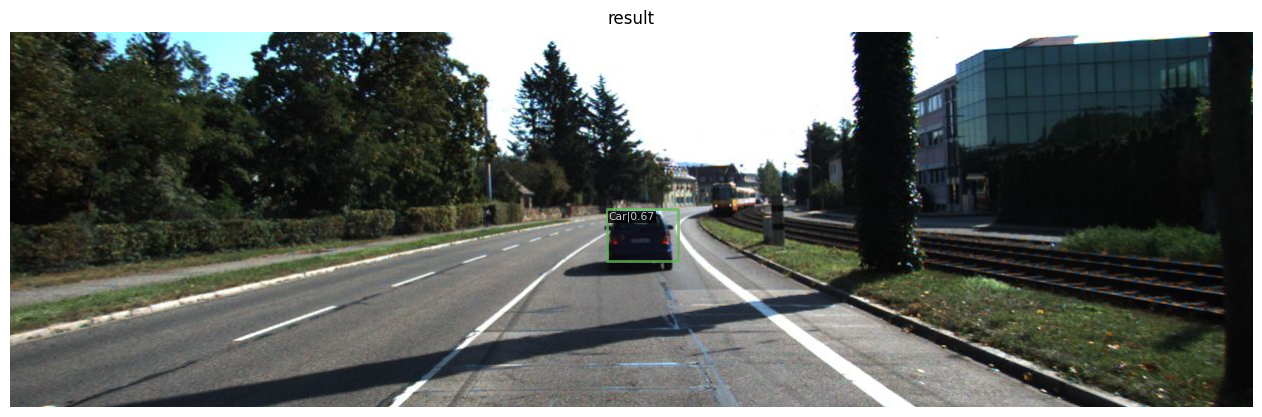

In [38]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

image = 'data/kitti_tiny/training/image_2/000071.jpeg'
model = init_detector('yolov3_kitti.py', 'work_dirs/latest.pth')
result = inference_detector(model, image)
show_result_pyplot(model, image, result)